# Motif Example Classifier  
A classifier CNN model, trained to classify novel examples of a given motif. 

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

### GPU Setup 

In [3]:
# Check that TensorFlow can see the GPU
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Set TensorFlow option to grow GPU memory allocation when required
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Data Augmentation

Store raw data at `./data/positive` and `./data/negative` and augment in place

### Make Spectrograms

Save spectrograms into `./data/train/{class}/{name}` and `./data/test/{class}/{name}`

### Load Spectrograms as Data Set

Data lives in `./data/train`

In [2]:
# Sort spectrograms into directories
# Use if loading directory of spectrograms

import os
import shutil
val_split = 8

for index, item in enumerate(os.listdir("./spec/negative/")):
    if index % val_split == 0: shutil.move("./spec/negative/" + item, "./test_data/negative/" + item)
    else: shutil.move("./spec/negative/" + item, "./train_data/negative/" + item)

for index, item in enumerate(os.listdir("./spec/positive/")):
    if index % val_split == 0: shutil.move("./spec/positive/" + item, "./test_data/positive/" + item)
    else: shutil.move("./spec/positive/" + item, "./train_data/positive/" + item)
        

In [5]:
train_directory = './train_data/'
test_directory = './test_data/'
image_size = (360,225) ## Specify the size of the spectrogram images

# Build the train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=image_size, seed=123)

# Build the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=image_size, seed=123)


class_names = train_ds.class_names
print(class_names)

Found 9322 files belonging to 2 classes.
Found 1332 files belonging to 2 classes.
['negative', 'positive']


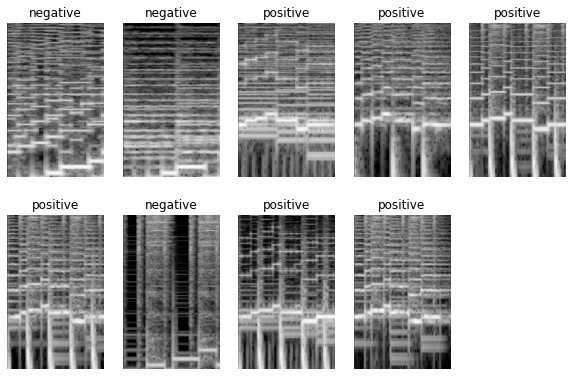

In [6]:
# Straight from the microsoft tutorial 
# shows the spectrograms with their labels
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Build the Model
Define the layers using Keras

In [7]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                            padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,
                            padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                                  padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[360, 225, 3],
                              padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filter = 64
for filters in [64]*3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filter else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(2, activation="softmax"))

In [9]:
learning_rate = 0.02

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.SGD(learning_rate)
metrics = ['acc']
model.compile(optimizer, loss_fn, metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 113, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 180, 113, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 113, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 57, 64)       0         
 )                                                               
                                                                 
 residual_unit (ResidualUnit  (None, 90, 57, 64)       74240     
 )                                                               
                                                        

In [10]:
# Set the epochs
epochs = 5
print('\nFitting:')

# Train the model.
history = model.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=16)


Fitting:
Epoch 1/5
292/292 [==============================] - 51s 141ms/step - loss: 0.0835 - acc: 0.9782 - val_loss: 0.1740 - val_acc: 0.9550
Epoch 2/5
292/292 [==============================] - 39s 133ms/step - loss: 0.0059 - acc: 0.9987 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3/5
292/292 [==============================] - 39s 132ms/step - loss: 0.0012 - acc: 0.9998 - val_loss: 9.3130e-04 - val_acc: 0.9992
Epoch 4/5
292/292 [==============================] - 38s 128ms/step - loss: 2.0824e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9992
Epoch 5/5
292/292 [==============================] - 37s 127ms/step - loss: 1.3972e-04 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 0.9992


### Train the Model

In [11]:
model.save("./model.tf")

INFO:tensorflow:Assets written to: ./model.tf\assets


INFO:tensorflow:Assets written to: ./model.tf\assets


### Evaluate the Model
Run the model throught the test data at `./data/test` and calculate accuracy.